[GMM] Added .sample(n, seed) method.
[Regular 3×3] baseline: E(0)=0 (should be 0)
[Regular 3×3] Threshold base = Ex; example mean at t=1 (REF) ≈ 0.9937
[Regular 3×3] Conditioning strength at t=1 (mass fraction ≥ Ec):
  β=0.5  |  ζ=0: (unconditional)  |  ζ=1: Ex=37.7%, Eyh=37.3%  |  ζ=2: Ex=14.7%, Eyh=14.5%
  β=1  |  ζ=0: (unconditional)  |  ζ=1: Ex=38.5%, Eyh=38.1%  |  ζ=2: Ex=14.7%, Eyh=14.3%
  β=5  |  ζ=0: (unconditional)  |  ζ=1: Ex=39.1%, Eyh=38.8%  |  ζ=2: Ex=14.9%, Eyh=14.5%
  β=10  |  ζ=0: (unconditional)  |  ζ=1: Ex=38.9%, Eyh=38.5%  |  ζ=2: Ex=14.6%, Eyh=14.4%
  β=15  |  ζ=0: (unconditional)  |  ζ=1: Ex=37.8%, Eyh=37.7%  |  ζ=2: Ex=15.1%, Eyh=14.9%
  β=30  |  ζ=0: (unconditional)  |  ζ=1: Ex=38.4%, Eyh=37.7%  |  ζ=2: Ex=15.1%, Eyh=14.9%


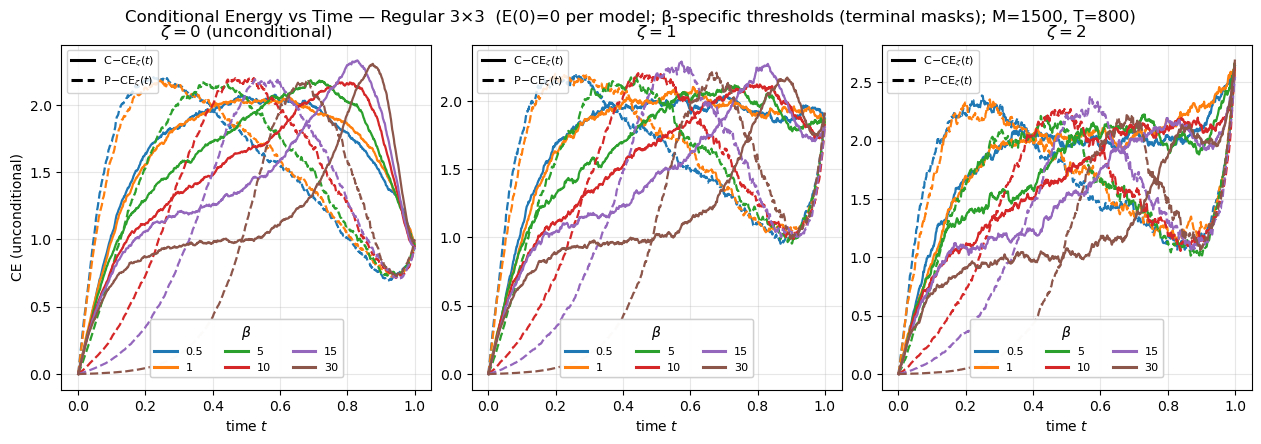

[saved] figs/CE_time_cond_panels_M1500_T800_betaTmask_noRP_regular_3x3.png
[Perturbed A] baseline: E(0)=0 (should be 0)
[Perturbed A] Threshold base = Ex; example mean at t=1 (REF) ≈ 0.0471
[Perturbed A] Conditioning strength at t=1 (mass fraction ≥ Ec):
  β=0.5  |  ζ=0: (unconditional)  |  ζ=1: Ex=44.7%, Eyh=44.5%  |  ζ=2: Ex=45.5%, Eyh=45.3%
  β=1  |  ζ=0: (unconditional)  |  ζ=1: Ex=45.9%, Eyh=45.7%  |  ζ=2: Ex=44.9%, Eyh=44.7%
  β=5  |  ζ=0: (unconditional)  |  ζ=1: Ex=46.9%, Eyh=46.9%  |  ζ=2: Ex=46.3%, Eyh=46.3%
  β=10  |  ζ=0: (unconditional)  |  ζ=1: Ex=47.0%, Eyh=47.1%  |  ζ=2: Ex=46.8%, Eyh=46.5%
  β=15  |  ζ=0: (unconditional)  |  ζ=1: Ex=47.0%, Eyh=47.1%  |  ζ=2: Ex=46.2%, Eyh=46.0%
  β=30  |  ζ=0: (unconditional)  |  ζ=1: Ex=45.5%, Eyh=45.4%  |  ζ=2: Ex=43.4%, Eyh=43.3%


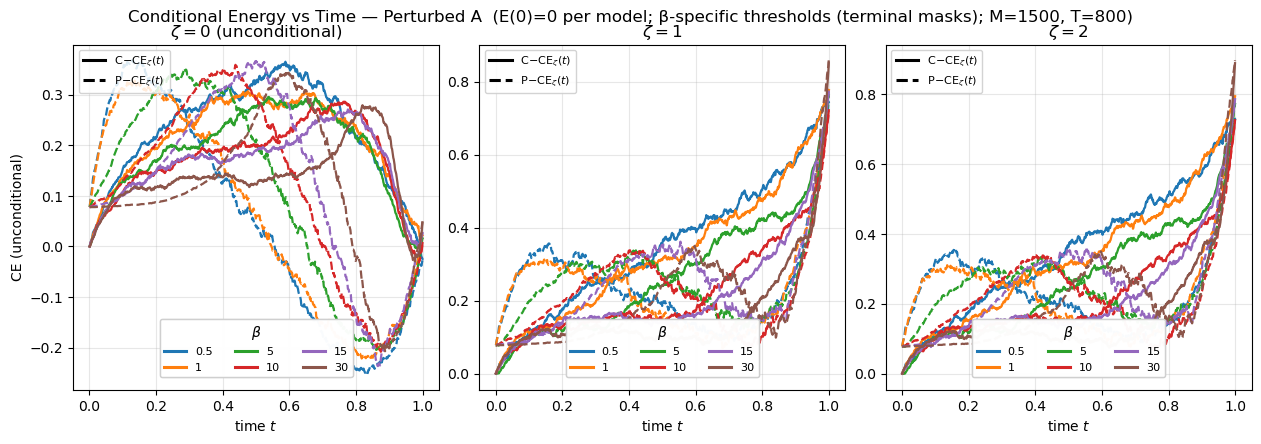

[saved] figs/CE_time_cond_panels_M1500_T800_betaTmask_noRP_perturbed_a.png
[Perturbed B] baseline: E(0)=0 (should be 0)
[Perturbed B] Threshold base = Ex; example mean at t=1 (REF) ≈ 0.6627
[Perturbed B] Conditioning strength at t=1 (mass fraction ≥ Ec):
  β=0.5  |  ζ=0: (unconditional)  |  ζ=1: Ex=50.6%, Eyh=50.2%  |  ζ=2: Ex=20.9%, Eyh=20.7%
  β=1  |  ζ=0: (unconditional)  |  ζ=1: Ex=49.5%, Eyh=49.2%  |  ζ=2: Ex=22.9%, Eyh=22.7%
  β=5  |  ζ=0: (unconditional)  |  ζ=1: Ex=49.6%, Eyh=49.3%  |  ζ=2: Ex=21.4%, Eyh=21.3%
  β=10  |  ζ=0: (unconditional)  |  ζ=1: Ex=47.5%, Eyh=47.3%  |  ζ=2: Ex=22.1%, Eyh=21.9%
  β=15  |  ζ=0: (unconditional)  |  ζ=1: Ex=49.3%, Eyh=48.7%  |  ζ=2: Ex=21.9%, Eyh=21.5%
  β=30  |  ζ=0: (unconditional)  |  ζ=1: Ex=49.6%, Eyh=49.5%  |  ζ=2: Ex=21.2%, Eyh=21.3%


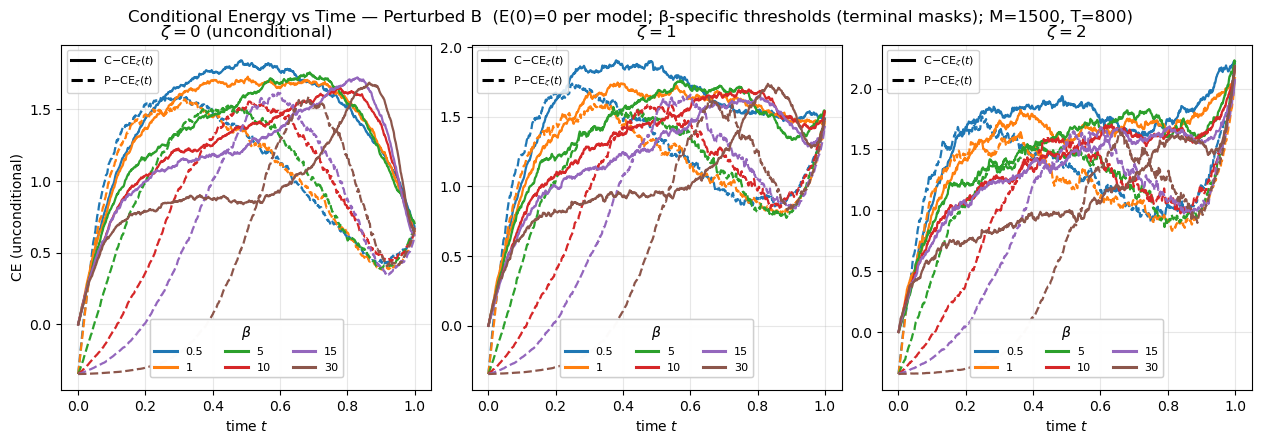

[saved] figs/CE_time_cond_panels_M1500_T800_betaTmask_noRP_perturbed_b.png


In [1]:
import sys
from ada_api_clean import *

# ============================================================
# Baseline: E(x) = -log p(x) + log p(0)  =>  E(0)=0 per model
#
# Terminal conditioning:
#   ζ=0  : unconditional (no mask).
#   ζ>0  : select trajectories by terminal-time mask at t=1 and
#          average entire time-series over that fixed subset.
#
# Threshold modes:
#   - "target"        : Ec(ζ) = ζ * mean_E_target                  (β-independent)
#   - "beta_terminal" : Ec^β(ζ) = ζ * mean_E_ref^β at t=1          (β- & model-specific)
# REF_SERIES (for beta_terminal): {"Ex","Eyh"}  (no rescaled series).
#
# Re-scaled (rP) REMOVED throughout.
# ============================================================
import os, math
import numpy as np
import matplotlib.pyplot as plt

os.makedirs("figs", exist_ok=True)

THRESH_MODE = "beta_terminal"   # "target" or "beta_terminal"
REF_SERIES  = "Ex"              # used only when THRESH_MODE == "beta_terminal"; choose "Ex" or "Eyh"

# ---------- stable GMM log-pdf (isotropic components) ----------
def _logsumexp(a, axis=-1):
    a_max = np.max(a, axis=axis, keepdims=True)
    out = a_max + np.log(np.sum(np.exp(a - a_max), axis=axis, keepdims=True))
    return np.squeeze(out, axis=axis)

def gmm_logpdf(X, gmm):
    X = np.asarray(X, float)                 # (N,d)
    MU  = np.asarray(gmm.MU, float)         # (K,d)
    SIG = np.asarray(gmm.SIG, float)        # (K,)  std per component
    PI  = np.asarray(gmm.PI, float)         # (K,)
    K,d = MU.shape
    dx = X[:, None, :] - MU[None, :, :]     # (N,K,d)
    sq = np.sum(dx*dx, axis=2)              # (N,K)
    inv_sig2 = 1.0 / (SIG**2)               # (K,)
    log_norm = -0.5 * d * np.log(2*np.pi*(SIG**2))  # (K,)
    log_comp = (np.log(PI)[None,:] + log_norm[None,:] - 0.5 * sq * inv_sig2[None,:])
    return _logsumexp(log_comp, axis=1)     # (N,)

# ---------- energy with per-model origin baseline: E(0)=0 ----------
_E_SHIFT_BY_ID = {}
def _ensure_energy_shift(gmm):
    key = id(gmm)
    if key not in _E_SHIFT_BY_ID:
        x0 = np.zeros((1, int(gmm.d)), dtype=float)
        _E_SHIFT_BY_ID[key] = float(gmm_logpdf(x0, gmm))   # shift = log p(0)

def energy(X, gmm):
    _ensure_energy_shift(gmm)
    return -gmm_logpdf(np.asarray(X, float), gmm) + _E_SHIFT_BY_ID[id(gmm)]

# ---------- simulate once; cache energies over time ----------
def simulate_and_collect_energies(sched, gmm, M=1500, T=800, seed=0):
    """
    Midpoint EM with unit diffusion, X(0)=0, midpoints t=(n+1/2)/T.
    Returns:
      tmid: (T,)
      Ex, Eyh: (T, M) energies under same baseline.
    """
    rng = np.random.default_rng(int(seed))
    d   = int(gmm.d)
    dt  = 1.0 / T
    tmid = (np.arange(T) + 0.5) / T

    X = np.zeros((M, d), dtype=float)
    Ex   = np.zeros((T, M), dtype=float)
    Eyh  = np.zeros((T, M), dtype=float)

    for n, t in enumerate(tmid):
        # ORIGINAL control: u = b^-(t) * ŷ - a^-(t) * X
        yhat = yhat_oracle_gmm(X, float(t), sched, gmm)
        a_m  = float(sched.a_minus(float(t)))
        b_m  = float(sched.b_minus(float(t)))
        u    = b_m * yhat - a_m * X

        # energies
        Ex[n, :]   = energy(X, gmm)
        Eyh[n, :]  = energy(yhat, gmm)

        # step
        dW = rng.normal(size=X.shape) * math.sqrt(dt)
        X  = X + u*dt + dW

    return tmid, Ex, Eyh

# ---------- build curves using TERMINAL masks (no rP) ----------
def curves_with_terminal_masks(Ex, Eyh, Ec_by_zeta, zetas=(0.0, 1.0, 2.0)):
    """
    For each ζ:
      - ζ=0: unconditional means over ALL samples (no mask).
      - ζ>0: terminal masks at t=1
          mC = (Ex[-1]  >= Ec) -> Cζ(t) = mean Ex[t][mC]
          mP = (Eyh[-1] >= Ec) -> Pζ(t) = mean Eyh[t][mP]
    """
    T = Ex.shape[0]
    out = {}
    for ζ in zetas:
        if float(ζ) == 0.0:
            Cζ = np.mean(Ex,   axis=1)
            Pζ = np.mean(Eyh,  axis=1)
        else:
            Ec = float(Ec_by_zeta[float(ζ)])
            mC  = (Ex[-1]  >= Ec)
            mP  = (Eyh[-1] >= Ec)
            Cζ = np.array([np.mean(Ex[t][mC])  if np.any(mC) else np.nan for t in range(T)])
            Pζ = np.array([np.mean(Eyh[t][mP]) if np.any(mP) else np.nan for t in range(T)])
        out[float(ζ)] = (Cζ, Pζ)
    return out

# ------------------ experiment settings ------------------
beta_list = [0.5, 1.0, 5.0, 10.0, 15.0, 30.0]
M, T = 1500, 800
seed = 20240919
zetas = [0.0, 1.0, 2.0]

models = [("Regular 3×3", regular), ("Perturbed A", pertA), ("Perturbed B", pertB)]

# ====================== plotting ======================
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
beta_colors = {float(b): colors[i % len(colors)] for i, b in enumerate(beta_list)}

def _plot_one_panel(ax, tmid, series_for_zeta, ζ):
    # style legend
    style_handles = [
        plt.Line2D([0],[0], color="k", lw=2.2, ls="-"),
        plt.Line2D([0],[0], color="k", lw=2.2, ls="--"),
    ]
    style_labels = [r"$\mathrm{C\!-\!CE}_\zeta(t)$",
                    r"$\mathrm{P\!-\!CE}_\zeta(t)$"]
    leg_style = ax.legend(style_handles, style_labels,
                          loc="upper left", fontsize=8, frameon=True, framealpha=0.85, borderpad=0.4)
    ax.add_artist(leg_style)

    # β curves
    handles_beta, labels_beta = [], []
    for b in beta_list:
        b = float(b)
        tmid_b, Cζ, Pζ = series_for_zeta[b]
        ax.plot(tmid_b, Cζ, lw=1.6, color=beta_colors[b], ls="-")
        ax.plot(tmid_b, Pζ, lw=1.6, color=beta_colors[b], ls="--")
        handles_beta.append(plt.Line2D([0],[0], color=beta_colors[b], lw=2.2))
        labels_beta.append(f"{b:g}")
    leg_beta = ax.legend(handles_beta, labels_beta,
                         loc="lower center", bbox_to_anchor=(0.5, 0.02),
                         ncol=3, fontsize=8, title=r"$\beta$",
                         frameon=True, framealpha=0.85, borderpad=0.4)
    ax.add_artist(leg_beta)

    if float(ζ) == 0.0:
        ax.set_ylabel(r"CE (unconditional)")
        ax.set_title(r"$\zeta=0$ (unconditional)")
    else:
        ax.set_title(fr"$\zeta={ζ:g}$")
    ax.set_xlabel("time $t$")
    ax.grid(True, alpha=0.3)

# ====================== run per model and draw ======================
for model_name, gmm in models:
    # sanity: E(0) must be 0 for each model
    E0_check = float(energy(np.zeros((1,int(gmm.d))), gmm))
    print(f"[{model_name}] baseline: E(0)={E0_check:.3g} (should be 0)")

    # For target-mode thresholds we need target mean once per model
    if THRESH_MODE == "target":
        rng_ref = np.random.default_rng(12345)
        Y_ref, _ = sample_gmm(gmm, 80000, rng_ref)
        E_target_mean = float(np.mean(energy(Y_ref, gmm)))
        Ec_target = {float(ζ): float(ζ) * E_target_mean for ζ in zetas}

    # simulate per β and build series
    series = {float(ζ): {} for ζ in zetas}   # series[ζ][β] = (tmid, Cζ, Pζ)
    mass_fracs = {}                          # mass≥Ec at t=1 (diagnostics)

    for b in beta_list:
        sched = BetaSchedulePWC.constant(float(b))
        _ = alpha_K_gamma_from_schedule(sched, 0.5)
        tmid, Ex, Eyh = simulate_and_collect_energies(
            sched, gmm, M=M, T=T, seed=seed + int(31*float(b))
        )

        # ---- define thresholds
        if THRESH_MODE == "target":
            Ec_by_zeta = Ec_target
            mean_ref_print = float(np.mean(energy(sample_gmm(gmm, 20000, np.random.default_rng(99))[0], gmm)))
        else:
            # β-specific, model-specific terminal thresholds:
            if REF_SERIES == "Ex":
                mean_ref_print = float(np.mean(Ex[-1]))
            elif REF_SERIES == "Eyh":
                mean_ref_print = float(np.mean(Eyh[-1]))
            else:
                raise ValueError("REF_SERIES must be 'Ex' or 'Eyh'")
            Ec_by_zeta = {float(ζ): float(ζ) * mean_ref_print for ζ in zetas}

        # curves under these thresholds (TERMINAL MASKS; no rP)
        curves = curves_with_terminal_masks(Ex, Eyh, Ec_by_zeta, zetas=zetas)
        for ζ in zetas:
            Cζ, Pζ = curves[ζ]
            series[float(ζ)][float(b)] = (tmid, Cζ, Pζ)

        # diagnostics: show conditioning strength at t=1 (only ζ>0 meaningful)
        mf = {}
        for ζ in zetas:
            if float(ζ) == 0.0:
                mf[float(ζ)] = dict(Ex=1.0, Eyh=1.0)  # unconditional
            else:
                Ec = Ec_by_zeta[float(ζ)]
                mf[float(ζ)] = dict(
                    Ex=float(np.mean(Ex[-1]  >= Ec)),
                    Eyh=float(np.mean(Eyh[-1] >= Ec)),
                )
        mass_fracs[float(b)] = mf

    # diagnostics printout
    print(f"[{model_name}] Threshold base = {REF_SERIES if THRESH_MODE=='beta_terminal' else 'target'}; "
          f"example mean at t=1 (REF) ≈ {mean_ref_print:.4g}")
    print(f"[{model_name}] Conditioning strength at t=1 (mass fraction ≥ Ec):")
    for b in beta_list:
        row = mass_fracs[float(b)]
        parts = []
        for ζ in zetas:
            m = row[float(ζ)]
            parts.append(
                f"ζ={ζ:g}: Ex={100*m['Ex']:.1f}%, Eyh={100*m['Eyh']:.1f}%"
                if float(ζ) != 0.0 else "ζ=0: (unconditional)"
            )
        print(f"  β={float(b):g}  |  " + "  |  ".join(parts))

    # draw a single 1×3 figure for this model (ζ=0,1,2)
    fig, axes = plt.subplots(1, 3, figsize=(12.5, 4.2), constrained_layout=True, sharex=True)
    for ax, ζ in zip(axes, [0.0, 1.0, 2.0]):
        _plot_one_panel(ax, tmid, series_for_zeta=series[float(ζ)], ζ=ζ)

    title_suffix = "β-specific thresholds (terminal masks)" if THRESH_MODE=="beta_terminal" else "target-only thresholds (terminal masks)"
    fig.suptitle(f"Conditional Energy vs Time — {model_name}  (E(0)=0 per model; {title_suffix}; M={M}, T={T})",
                 y=1.02, fontsize=12)
    fname = f"figs/CE_time_cond_panels_M{M}_T{T}_" + \
            ("betaTmask_noRP_" if THRESH_MODE=="beta_terminal" else "targetmask_noRP_") + \
            model_name.lower().replace("×","x").replace(" ", "_").replace("(","").replace(")","") + ".png"
    fig.savefig(fname, dpi=300, bbox_inches="tight")
    plt.show(); print("[saved]", fname)
